In [34]:
import numpy as np
import pandas as pd
from ast import literal_eval
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Reader, Dataset, SVD, KNNBaseline
from surprise.model_selection import cross_validate
import seaborn as sn
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import plotly.graph_objs as go 
import pylab as pl
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import preprocessing
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import datetime
from holidays import WEEKEND, HolidayBase
from dateutil.easter import easter
from dateutil.relativedelta import relativedelta as rd
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
credits = pd.read_csv('credits.csv')
moviesMetaData = pd.read_csv('movies_metadata.csv',low_memory=False)
keywords = pd.read_csv('keywords.csv')
ratings = pd.read_csv('ratings_small.csv')

In [36]:
ratings.rename(columns={'movieId': 'id'}, inplace = True)

In [37]:
moviesMetaData['id'] = moviesMetaData['id'].astype(str)
credits['id'] = credits['id'].astype(str)
keywords['id'] = keywords['id'].astype(str)
ratings['id'] = ratings['id'].astype(str)

In [38]:
ratings = ratings[['id']]
ratings = ratings.drop_duplicates()

moviesMetaData = pd.merge(moviesMetaData,ratings, on='id')

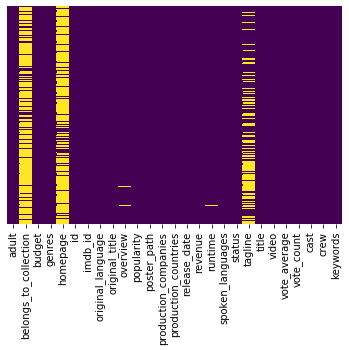

In [7]:
mainList= pd.merge(moviesMetaData, credits, on='id')
mainList= pd.merge(mainList,keywords, on='id')
corrMatrix = mainList.corr()
sn.heatmap(mainList.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')

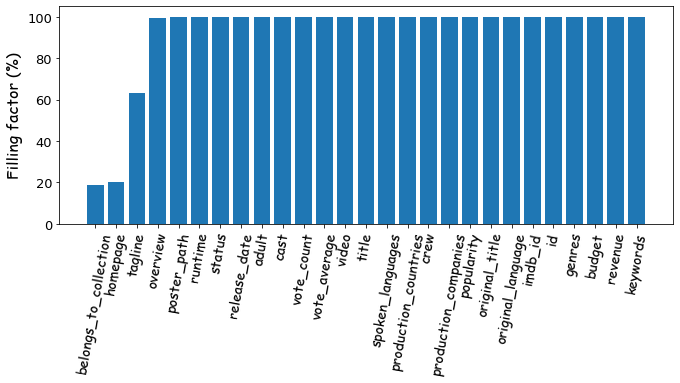

In [9]:
def missingDF(data):
    missing_df = data.isnull().sum(axis=0).reset_index()
    missing_df.columns = ['column_name', 'missing_count']
    missing_df['filling_factor'] = (mainList.shape[0] 
                                    - missing_df['missing_count']) / mainList.shape[0] * 100
    missing_df.sort_values('filling_factor').reset_index(drop = True)
    
    missing_df = missing_df.sort_values('filling_factor').reset_index(drop = True)
    y_axis = missing_df['filling_factor'] 
    x_label = missing_df['column_name']
    x_axis = missing_df.index

    fig = plt.figure(figsize=(11, 4))
    plt.xticks(rotation=80, fontsize = 14)
    plt.yticks(fontsize = 13)

    plt.xticks(x_axis, x_label,family='fantasy', fontsize = 14 )
    plt.ylabel('Filling factor (%)', family='fantasy', fontsize = 16)
    plt.bar(x_axis, y_axis);
    
    return missing_df

table = missingDF(mainList)

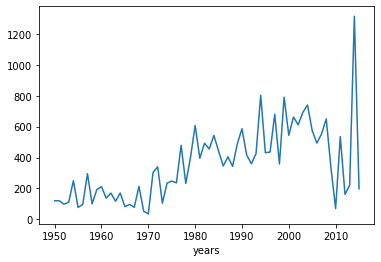

In [10]:
mainList['release_date'] =  pd.to_datetime(mainList['release_date']) 
mainList['years'] = mainList['release_date'].apply(lambda x: x.year)

mainList[(mainList['years'] < 2019) & (mainList['years'] >= 1950)].groupby(by = 'years').mean()['vote_count'].plot()

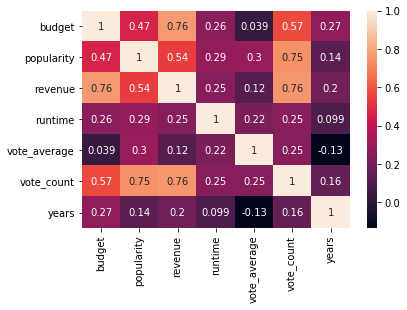

In [11]:
mainList['budget'] = mainList['budget'].astype(float)
mainList['popularity'] = mainList['popularity'].astype(float)
sn.heatmap(mainList.corr(), annot=True)

In [12]:
mainList = mainList[['id', 'title', 'cast', 'crew', 'keywords', 'genres']]
mainList.head(5)

,id,title,cast,crew,keywords,genres
0,949,Heat,"[{'cast_id': 25, 'character': 'Lt. Vincent Han...","[{'credit_id': '52fe4292c3a36847f802916d', 'de...","[{'id': 642, 'name': 'robbery'}, {'id': 703, '...","[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam..."
1,710,GoldenEye,"[{'cast_id': 1, 'character': 'James Bond', 'cr...","[{'credit_id': '52fe426ec3a36847f801e14b', 'de...","[{'id': 701, 'name': 'cuba'}, {'id': 769, 'nam...","[{'id': 12, 'name': 'Adventure'}, {'id': 28, '..."
2,1408,Cutthroat Island,"[{'cast_id': 1, 'character': 'Morgan Adams', '...","[{'credit_id': '52fe42f4c3a36847f802f69f', 'de...","[{'id': 911, 'name': 'exotic island'}, {'id': ...","[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam..."
3,524,Casino,"[{'cast_id': 4, 'character': ""Sam 'Ace' Rothst...","[{'credit_id': '52fe424dc3a36847f80139cd', 'de...","[{'id': 383, 'name': 'poker'}, {'id': 726, 'na...","[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name..."
4,4584,Sense and Sensibility,"[{'cast_id': 6, 'character': 'Marianne Dashwoo...","[{'credit_id': '52fe43cec3a36847f807101f', 'de...","[{'id': 420, 'name': 'bowling'}, {'id': 818, '...","[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n..."


In [13]:
features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    mainList[feature] = mainList[feature].apply(literal_eval)
    
mainList.head()

,id,title,cast,crew,keywords,genres
0,949,Heat,"[{'cast_id': 25, 'character': 'Lt. Vincent Han...","[{'credit_id': '52fe4292c3a36847f802916d', 'de...","[{'id': 642, 'name': 'robbery'}, {'id': 703, '...","[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam..."
1,710,GoldenEye,"[{'cast_id': 1, 'character': 'James Bond', 'cr...","[{'credit_id': '52fe426ec3a36847f801e14b', 'de...","[{'id': 701, 'name': 'cuba'}, {'id': 769, 'nam...","[{'id': 12, 'name': 'Adventure'}, {'id': 28, '..."
2,1408,Cutthroat Island,"[{'cast_id': 1, 'character': 'Morgan Adams', '...","[{'credit_id': '52fe42f4c3a36847f802f69f', 'de...","[{'id': 911, 'name': 'exotic island'}, {'id': ...","[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam..."
3,524,Casino,"[{'cast_id': 4, 'character': 'Sam 'Ace' Rothst...","[{'credit_id': '52fe424dc3a36847f80139cd', 'de...","[{'id': 383, 'name': 'poker'}, {'id': 726, 'na...","[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name..."
4,4584,Sense and Sensibility,"[{'cast_id': 6, 'character': 'Marianne Dashwoo...","[{'credit_id': '52fe43cec3a36847f807101f', 'de...","[{'id': 420, 'name': 'bowling'}, {'id': 818, '...","[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n..."


In [14]:
def getDirector(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [15]:
def getFirstThree(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        
        if len(names) > 3:
            names = names[:3]
        return names

    return []

In [16]:
mainList['director'] = mainList['crew'].apply(getDirector)

features = ['cast', 'keywords', 'genres']

for feature in features:
    mainList[feature] = mainList[feature].apply(getFirstThree)
mainList[['title', 'cast', 'director', 'keywords', 'genres']].head(3)

,title,cast,director,keywords,genres
0,Heat,"[Al Pacino, Robert De Niro, Val Kilmer]",Michael Mann,"[robbery, detective, bank]","[Action, Crime, Drama]"
1,GoldenEye,"[Pierce Brosnan, Sean Bean, Izabella Scorupco]",Martin Campbell,"[cuba, falsely accused, secret identity]","[Adventure, Action, Thriller]"
2,Cutthroat Island,"[Geena Davis, Matthew Modine, Frank Langella]",Renny Harlin,"[exotic island, treasure, map]","[Action, Adventure]"


In [19]:
def counting_values(df, column):
    value_count = {}
    for row in df[column].dropna():
        if len(row) > 0:
            for key in row:
                if key in value_count:
                    value_count[key] += 1
                else:
                    value_count[key] = 1
        else:
            pass
    return value_count
def count_director(df, column):
    value_count = {}
    for key in df[column].dropna():
        if key in value_count:
            value_count[key] += 1
        else:
            value_count[key] = 1
        
    return value_count

In [20]:
def hist(data):
    iData = dict(sorted(data.items(), key=lambda x: x[1],reverse=True)[:20])
    pos = np.arange(len(iData.keys()))
    width = 1.0
    
    ax = plt.axes()
    ax.set_xticks(pos + (width / 2))
    ax.set_xticklabels(iData.keys())
    plt.yticks(fontsize = 15)
    plt.xticks(rotation=85, fontsize = 15)
    plt.grid()
    plt.bar(iData.keys(), iData.values(), width, align = 'center', color='g')
    plt.show()
    
def createWordCloud(data):
    wordcloud = WordCloud(max_font_size=100)

    wordcloud.generate_from_frequencies(data)
     
    plt.figure(figsize=[10.1,10.1])
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")

    plt.show()
    genres_count = pd.Series(data)
    genres_count.sort_values(ascending = False).head(20).plot(kind = 'bar', grid='True')

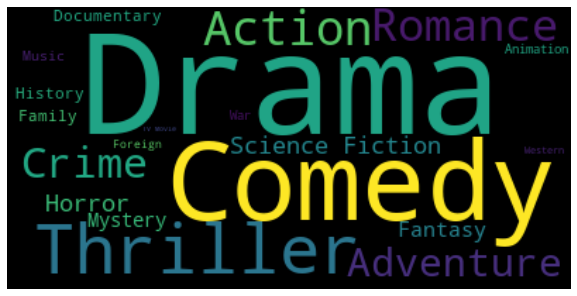

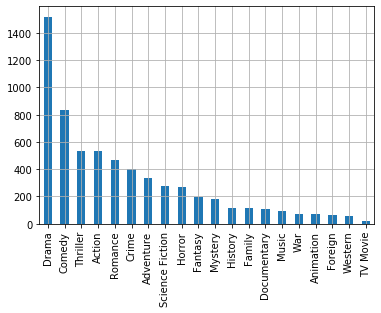

In [21]:
createWordCloud(counting_values(mainList, 'genres'))

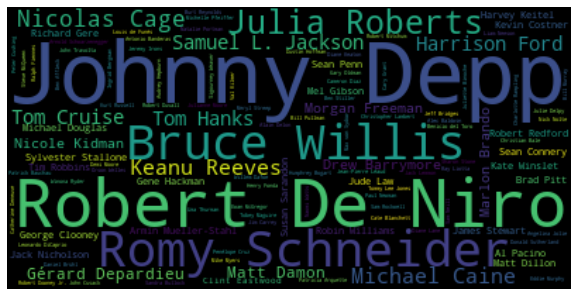

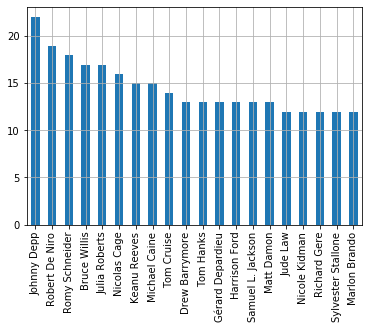

In [22]:
createWordCloud(counting_values(mainList, 'cast'))

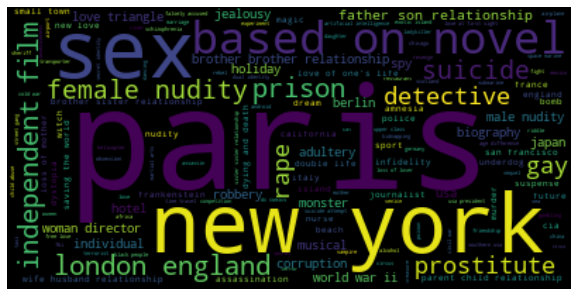

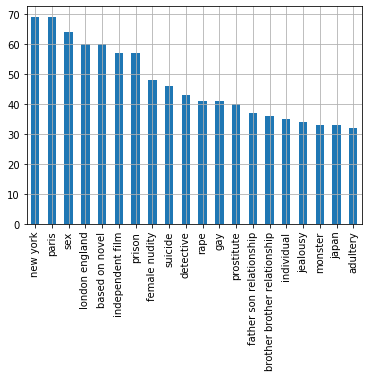

In [23]:
createWordCloud(counting_values(mainList, 'keywords'))

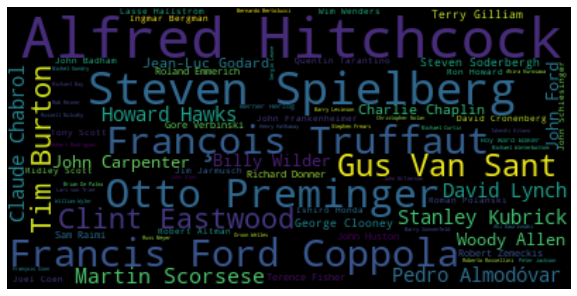

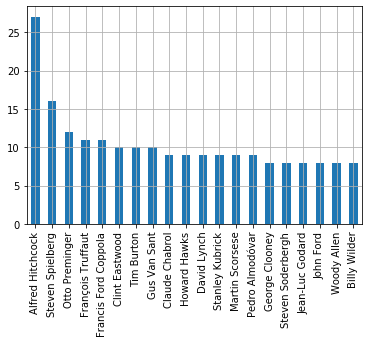

In [24]:
createWordCloud(count_director(mainList, 'director'))

In [25]:
def deletingSpaces(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''
        
features = ['cast', 'keywords', 'director']

for feature in features:
    mainList[feature] = mainList[feature].apply(deletingSpaces)
    
mainList.head(5)

,id,title,cast,crew,keywords,genres,director
0,949,Heat,"[alpacino, robertdeniro, valkilmer]","[{'credit_id': '52fe4292c3a36847f802916d', 'de...","[robbery, detective, bank]","[Action, Crime, Drama]",michaelmann
1,710,GoldenEye,"[piercebrosnan, seanbean, izabellascorupco]","[{'credit_id': '52fe426ec3a36847f801e14b', 'de...","[cuba, falselyaccused, secretidentity]","[Adventure, Action, Thriller]",martincampbell
2,1408,Cutthroat Island,"[geenadavis, matthewmodine, franklangella]","[{'credit_id': '52fe42f4c3a36847f802f69f', 'de...","[exoticisland, treasure, map]","[Action, Adventure]",rennyharlin
3,524,Casino,"[robertdeniro, sharonstone, joepesci]","[{'credit_id': '52fe424dc3a36847f80139cd', 'de...","[poker, drugabuse, 1970s]","[Drama, Crime]",martinscorsese
4,4584,Sense and Sensibility,"[katewinslet, emmathompson, hughgrant]","[{'credit_id': '52fe43cec3a36847f807101f', 'de...","[bowling, basedonnovel, servant]","[Drama, Romance]",anglee


In [26]:
def combineKeywords(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])

mainList['myKeywords'] = mainList.apply(combineKeywords, axis=1)

mainList['myKeywords'].head(5)

0    robbery detective bank alpacino robertdeniro v...
1    cuba falselyaccused secretidentity piercebrosn...
2    exoticisland treasure map geenadavis matthewmo...
3    poker drugabuse 1970s robertdeniro sharonstone...
4    bowling basedonnovel servant katewinslet emmat...
Name: myKeywords, dtype: object

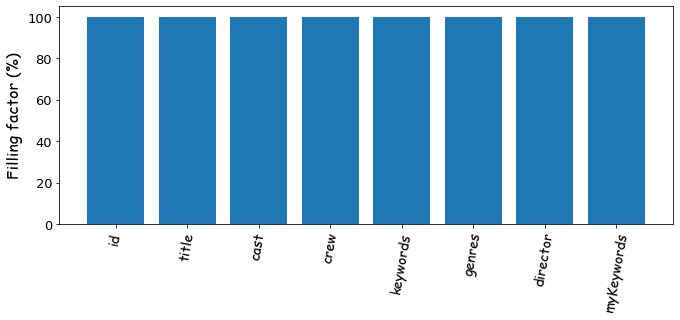

In [27]:
table = missingDF(mainList)

In [28]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(mainList['myKeywords'])
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [29]:
mainList = mainList.reset_index()
indices = pd.Series(mainList.index, index=mainList['title'])

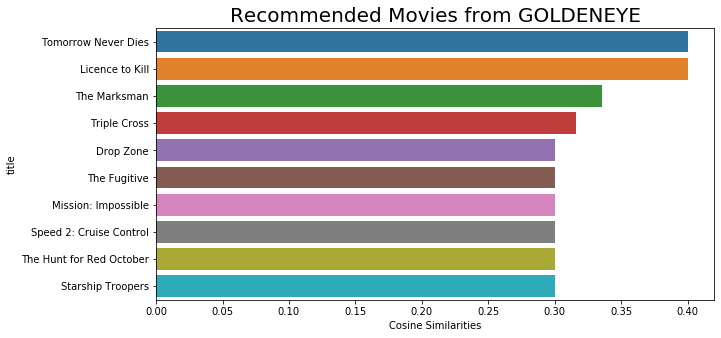

In [33]:
def get_recommendations(title, cosine_sim=cosine_sim):
    idx = indices[title]

    sim_scores = list(enumerate(cosine_sim[idx]))

    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    sim_scores = sim_scores[1:11]

    movie_indices = [i[0] for i in sim_scores]
    
    sim_value = [x[1] for x in sim_scores]
    
    result = indices.iloc[movie_indices]
    
    result[0:10] = sim_value

    return(result)
def show(title):
    result = get_recommendations(title)

    plt.figure(figsize=(10,5))
    sn.barplot(x = result[0:10], y=result.index)
    plt.title("Recommended Movies from " + str.upper(title), fontdict= {'fontsize' :20})
    plt.xlabel("Cosine Similarities")
    plt.show()
    
show('GoldenEye')